In [3]:
import numpy as np
from manifold_utils.mSVD import hypersphere, eigen_plot, eigen_calc_from_dist_mat
from sklearn.metrics.pairwise import euclidean_distances

In [17]:
Patches = np.load('Denoised3x3Patches.npy')
dist_mat = euclidean_distances(Patches)

(10000, 8)


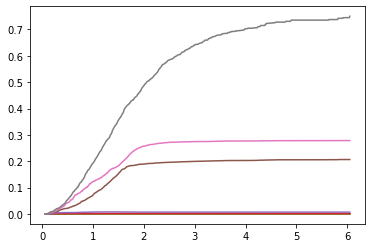

In [3]:
#Plot the radii vs eigvalues value for a center point
cid = 8000
radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(Patches, dist_mat, cid, radint = .01)
rmin = radii[0]
rmax = radii[-1]
eigen_plot(eigval_list, radii, rmin, rmax)

In [4]:
from combined_mls_pca import mls_pca
from PatchExtractTools import fnameFix

In [5]:
def SaveLocalPCAs(cloud, cids, k, dist_mat):
    for cid in cids:
        data = np.array(mls_pca(cloud, cid, k, radint = .01, iter=False, dist=dist_mat), dtype=object)
        fn = 'mls_pca_natural_images_data\cid=' + fnameFix(str(cid))
        #np.save(fn, data)
        
#select random center points
num_cids = 1
cids = np.random.choice(np.arange(Patches.shape[0]), size=num_cids)
#intrinsic dimensionality
k = 2
#save ensembles of hyperplanes
SaveLocalPCAs(Patches, cids, k, dist_mat)



(563, 8)
(563, 2, 8)
(563,)
()
()
(9993, 8)
(563, 6, 8)


In [1]:
import os
from manifold_utils.iga import iga

In [13]:
#prune the eigvecs and use those to get average hyperplanes. 
def GrassmannAvg():
    dirName = 'mls_pca_natural_images_data'
    listdirNames = os.listdir(dirName)
    G_hyperplanes = []
    cids = []
    for fn in listdirNames:
        #read a sample data
        filename = dirName + '\\' + fn
        eigval_list, top_eigvecs, new_radii, R_min, R_max, X_mat, bottom_eigvecs = np.load(filename, allow_pickle=True)    
        #record center id
        cids.append(int(fn[4:-4]))
        #find indices for Rmax and Rmin
        R_min_index, R_max_index = np.searchsorted(new_radii, np.array([R_min, R_max]))
        #Take only the top_eigvecs between R_min and R_max
        pruned_top_eigvecs = np.transpose(top_eigvecs[R_min_index:R_max_index], axes=(0,2,1))    
        #Grassmann averaged hyperplanes in dimension N-by-d. For natural images, 8x2.
        G_hyperplanes.append(iga(pruned_top_eigvecs))
    G_hyperplanes = np.array(G_hyperplanes)
    cids = np.array(cids)
    return cids, G_hyperplanes                            

In [14]:
cids, G_hyperplanes = GrassmannAvg() 

In [37]:
np.savez("GrassmannAvg", cids, G_hyperplanes)

In [16]:
from manifold_utils.transition_maps import len_shortest_path

In [43]:
def allPairsHeuristic(Patches, cids, GH):
    '''
    Compute Heuristic for all pairs 
    cid: id of the center points
    GH:Grassmann hyperplanes
    '''
    #heuristic matrix
    n = len(cids)
    hs = np.zeros((n,n))
    for i in range(n):
        #extract i-th cid point
        p_i = Patches[cids[i]]
        #extract i-th cid Grassmann average hyperplanes
        GH_i = GH[i]
        for j in range(i+1, n):
            GH_j = GH[j]
            p_j = Patches[cids[j]]
            #compute heuristic and update 
            h = len_shortest_path(p_i, GH_i, p_j, GH_j)
            #print(p_i, p_j, GH_i, GH_j, h)
            hs[i,j] = h
            hs[j,i] = h
    return hs
            
cids= np.load('GrassmannAvg.npz')['arr_0']  
G_hyperplanes= np.load('GrassmannAvg.npz')['arr_1']  
#hs = allPairsHeuristic(Patches, cids, G_hyperplanes)

(100, 8, 2)


In [20]:
import matplotlib.pyplot as plt

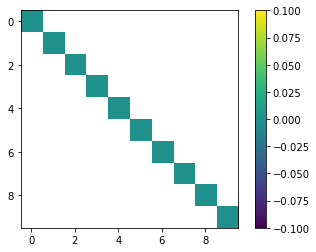

In [26]:
plt.imshow(hs, cmap='viridis')
plt.colorbar()
plt.show()

In [27]:
print(hs)

[[ 0. nan nan ... nan nan nan]
 [nan  0. nan ... nan nan nan]
 [nan nan  0. ... nan nan nan]
 ...
 [nan nan nan ...  0. nan nan]
 [nan nan nan ... nan  0. nan]
 [nan nan nan ... nan nan  0.]]
